# KAIST ANLAB Twitter Social Graph (`twitter_rv.net`) — Dataset Overview Notebook

**Goal:** provide a lightweight, reusable overview of the *social graph* released alongside the paper *“What is Twitter, a Social Network or a News Media?” (WWW 2010)*.

This notebook provides initial analysis for kwak10twitter, dataset **WWW2010 Twitter social graph** which is a **directed edge list** (`USER \t FOLLOWER`).

**What you will get here:**
- sanity checks (file presence, parsing)
- schema inspection + sample rows
- streaming-friendly descriptive statistics (edge count, degree summaries)
- quick plots on sampled data (degree distributions)
- optional NetworkX analysis on a sampled subgraph (SCC / WCC sizes, reciprocity estimate)

> The full dataset is very large (~26 GB uncompressed per the dataset page), so by default we compute **streaming stats** and use **sampling** for heavier graph operations.


## 1. Environment Setup

We import standard libraries and set a couple of convenience options. The code is written so you can run it on a laptop *as long as you avoid full in-memory operations on the complete edge list*.


In [1]:
import os
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
np.random.seed(42)


## 2. Dataset Location & Download Notes

The dataset is distributed as **multiple parts** in the GitHub release `twitter_rv.net`. On Linux/macOS you typically download the `*.gz` parts and concatenate them into a single file.

From the ANLAB dataset page, the **edge list format** is:

```
USER<TAB>FOLLOWER
```

- `USER` and `FOLLOWER` are numeric Twitter user IDs (integers)
- each line indicates: `FOLLOWER` follows `USER` (i.e., edge direction is **USER \u2190 FOLLOWER**)

### Recommended folder structure

Place the final edge list at:

```
data/twitter_rv/twitter_rv.net
```

…or update `DATA_DIR` below.

### Download commands (for reference)

These commands are shown for convenience; you can also download via your browser.

```bash
mkdir -p data/twitter_rv && cd data/twitter_rv
wget https://github.com/ANLAB-KAIST/traces/releases/download/twitter_rv.net/twitter_rv.net.00.gz
wget https://github.com/ANLAB-KAIST/traces/releases/download/twitter_rv.net/twitter_rv.net.01.gz
wget https://github.com/ANLAB-KAIST/traces/releases/download/twitter_rv.net/twitter_rv.net.02.gz
wget https://github.com/ANLAB-KAIST/traces/releases/download/twitter_rv.net/twitter_rv.net.03.gz
gunzip -c twitter_rv.net.00.gz twitter_rv.net.01.gz twitter_rv.net.02.gz twitter_rv.net.03.gz > twitter_rv.net
```

> If you already have `twitter_rv.net` as a single file, you can skip concatenation.


In [8]:
from pathlib import Path
import sys

def find_repo_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "src").is_dir():
            return p
    raise FileNotFoundError("Could not find repo root containing `src/`")

REPO_ROOT = find_repo_root()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from src.core.config import SETTINGS  # noqa: E402

print("REPO_ROOT:", REPO_ROOT)
print("DATA_ROOT:", SETTINGS.DATA_ROOT)

REPO_ROOT: /mnt/c/Users/rescic/PycharmProjects/dezinfo-datasets
DATA_ROOT: /home/rescic/dezinfo_data


In [9]:
DATASET_SUBDIR = "kwak10twitter"   # <-- set to your mount folder name
DATASET_DIR = Path(SETTINGS.DATA_ROOT) / DATASET_SUBDIR
assert DATASET_DIR.exists(), f"Mounted dataset folder not found: {DATASET_DIR}"
print("DATASET_DIR:", DATASET_DIR)

DATASET_DIR: /home/rescic/dezinfo_data/kwak10twitter


In [10]:
def find_net_file(dataset_dir: Path, preferred_name: str = "twitter_rv.net") -> Path:
    preferred = dataset_dir / preferred_name
    if preferred.exists():
        return preferred

    # otherwise search recursively
    matches = list(dataset_dir.rglob("*.net"))
    assert matches, f"No .net files found under: {dataset_dir}"
    # prefer a file that contains "twitter" in the name
    matches_sorted = sorted(matches, key=lambda p: ("twitter" not in p.name.lower(), p.name))
    return matches_sorted[0]

NET_PATH = find_net_file(DATASET_DIR, "twitter_rv.net")
print("NET_PATH:", NET_PATH)


NET_PATH: /home/rescic/dezinfo_data/kwak10twitter/twitter_rv.net


## 3. Fast Reading Helpers

Because the full file can be huge, we implement two helpers:

1) `read_head(...)` reads only the first *n* rows (sanity check + schema).
2) `stream_edges(...)` yields pandas DataFrames in **chunks** so we can compute counts without loading everything at once.

Both functions assume tab-separated integer columns.


In [11]:
from typing import Iterator, Optional, Tuple

def parse_pajek_edges(
    path: Path,
    keep_weight: bool = False,
) -> Iterator[Tuple[int, int] | Tuple[int, int, float]]:
    """
    Yields edges from a Pajek .net file.
    Supports sections: *Edges, *Arcs (and list variants).
    Pajek node ids are typically 1-based.
    """
    in_edges_section = False

    with path.open("r", encoding="utf-8", errors="replace") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue

            low = line.lower()
            if low.startswith("*vertices"):
                # Example: "*Vertices 11316811"
                # We don't need to do anything here for parsing edges.
                in_edges_section = False
                continue

            if low.startswith("*edges") or low.startswith("*arcs"):
                in_edges_section = True
                continue

            if low.startswith("*"):
                # Some other section
                in_edges_section = False
                continue

            if not in_edges_section:
                continue

            # Edge line: "u v [w]"
            parts = line.split()
            if len(parts) < 2:
                continue

            u = int(parts[0])
            v = int(parts[1])

            if keep_weight and len(parts) >= 3:
                try:
                    w = float(parts[2])
                except ValueError:
                    w = 1.0
                yield (u, v, w)
            else:
                yield (u, v)


def read_head(path: Path, nrows: int = 10) -> pd.DataFrame:
    """Read a small prefix of the edge list for schema/sanity checks."""
    return pd.read_csv(
        path,
        sep='\t',
        header=None,
        names=['user', 'follower'],
        nrows=nrows,
        dtype={'user': 'int64', 'follower': 'int64'},
        engine='c',
    )


def stream_edges(path: Path, chunksize: int = 2_000_000):
    """Stream the edge list as DataFrame chunks."""
    for chunk in pd.read_csv(
        path,
        sep='\t',
        header=None,
        names=['user', 'follower'],
        dtype={'user': 'int64', 'follower': 'int64'},
        chunksize=chunksize,
        engine='c',
    ):
        yield chunk


## 4. Schema Inspection (First Rows)

This is the quickest way to verify:

- the file exists
- parsing works
- both columns are integers

If this fails, double-check that the file was concatenated/decompressed correctly and that it is tab-separated.


In [ ]:
import itertools

peek = list(itertools.islice(parse_pajek_edges(NET_PATH, keep_weight=False), 5))
peek

## 5. Streaming-Friendly Descriptive Statistics

Here we compute basic graph statistics without reading the entire file into memory.

### What we compute

- **#edges**: simply the total number of lines processed
- **degree summaries** (in-degree / out-degree) for the nodes we observe

### Notes on direction

Each row is `user, follower`, meaning:

- `follower -> user` is the logical direction of the follow relation
- `user` receives **in-degree** from its followers
- `follower` receives **out-degree** from the users it follows

To keep the notebook intuitive, we compute:

- `in_degree[user] += 1`
- `out_degree[follower] += 1`

> Full exact distinct-node tracking can still be memory heavy (tens of millions of nodes). We keep `Counter`s for degrees; this is often feasible on a workstation, but if it is too big for your machine, use the sampling section below.


In [14]:
def streaming_degree_stats(path: Path, chunksize: int = 2_000_000, max_chunks: int | None = None):
    """Compute streaming edge count + degree Counters.

    Parameters
    ----------
    max_chunks : if set, only process this many chunks (useful for quick runs).
    """
    in_deg = Counter()
    out_deg = Counter()
    edges = 0
    
    for i, df in enumerate(stream_edges(path, chunksize=chunksize)):
        edges += len(df)
        in_deg.update(df['user'].to_numpy())
        out_deg.update(df['follower'].to_numpy())
        
        if max_chunks is not None and (i + 1) >= max_chunks:
            break
    
    return {
        'edges': edges,
        'in_deg': in_deg,
        'out_deg': out_deg,
    }


In [16]:
# Quick run tip:
# - Start with max_chunks=1 or 2 to validate runtime/memory.
# - Then set max_chunks=None for a full pass (may take a while depending on disk).

stats = streaming_degree_stats(NET_PATH, chunksize=2_000_000, max_chunks=1)

{
    'edges_processed': stats['edges'],
    'distinct_users_seen_as_user': len(stats['in_deg']),
    'distinct_users_seen_as_follower': len(stats['out_deg']),
}

{'edges_processed': 2000000,
 'distinct_users_seen_as_user': 2,
 'distinct_users_seen_as_follower': 1735424}

### Degree summary (from the processed portion)

Even from a small prefix, you can verify the scale and rough skew.

If you ran only `max_chunks=1`, treat the results below as **partial** and mainly for sanity checks.


In [17]:
def summarize_degrees(counter: Counter) -> pd.Series:
    vals = np.fromiter(counter.values(), dtype=np.int64)
    if len(vals) == 0:
        return pd.Series(dtype='float64')
    return pd.Series({
        'nodes': int(len(vals)),
        'min': int(vals.min()),
        'p50': float(np.quantile(vals, 0.50)),
        'p90': float(np.quantile(vals, 0.90)),
        'p99': float(np.quantile(vals, 0.99)),
        'max': int(vals.max()),
        'mean': float(vals.mean()),
    })

deg_summary = pd.DataFrame({
    'in_degree': summarize_degrees(stats['in_deg']),
    'out_degree': summarize_degrees(stats['out_deg']),
})

deg_summary

,in_degree,out_degree
nodes,2.00,1.735424e+06
min,998939.00,1.000000e+00
p50,1000000.00,1.000000e+00
p90,1000848.80,2.000000e+00
p99,1001039.78,2.000000e+00
max,1001061.00,2.000000e+00
mean,1000000.00,1.152456e+00


## 6. Sampling for Heavier Analyses

Many analyses (connected components, SCCs, path lengths, reciprocity) require an in-memory graph, which is not feasible for the entire dataset.

Instead, we create a **uniform-ish sample of edges** by reading chunks and keeping a random subset from each chunk.

### Sampling strategy

- For each chunk, we sample `k` rows without replacement.
- We concatenate all sampled rows to create a manageable edge list.

You can adjust `edges_per_chunk` to trade off quality vs memory.


In [18]:
def sample_edges(path: Path, chunksize: int = 2_000_000, edges_per_chunk: int = 50_000, max_chunks: int | None = None) -> pd.DataFrame:
    samples = []
    for i, df in enumerate(stream_edges(path, chunksize=chunksize)):
        if edges_per_chunk >= len(df):
            samp = df
        else:
            samp = df.sample(n=edges_per_chunk, random_state=42)
        samples.append(samp)
        if max_chunks is not None and (i + 1) >= max_chunks:
            break
    return pd.concat(samples, ignore_index=True)


# Start small; increase max_chunks / edges_per_chunk when you're happy with runtime.
sample = sample_edges(NET_PATH, chunksize=2_000_000, edges_per_chunk=50_000, max_chunks=2)

sample.shape

(100000, 2)

### Quick plots: sampled degree distributions

We compute degrees on the sampled edge list and plot them on log-log scales (common for social graphs).

> These are **not** exact full-graph distributions; they are only meant to give a fast overview.


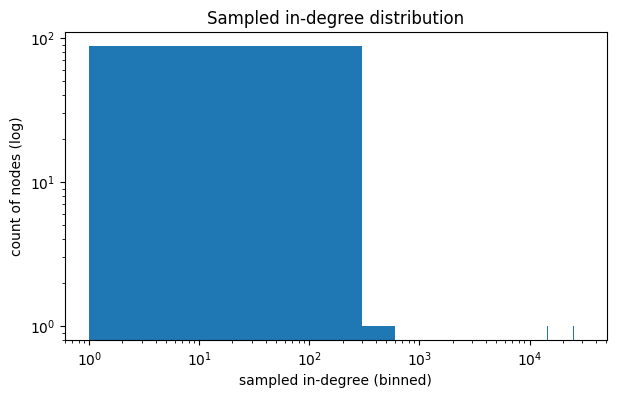

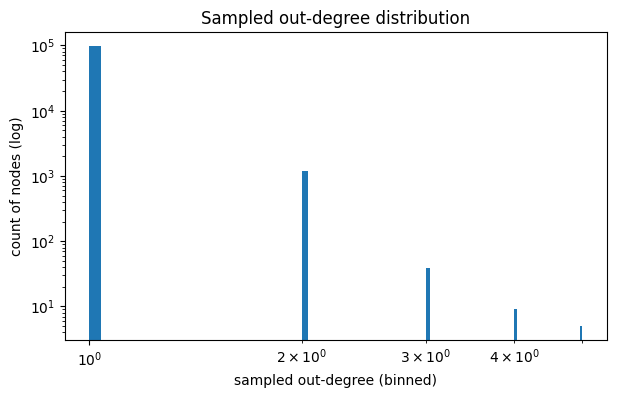

In [19]:
import matplotlib.pyplot as plt

sample_in = sample['user'].value_counts()
sample_out = sample['follower'].value_counts()

plt.figure(figsize=(7,4))
plt.hist(sample_in.values, bins=100, log=True)
plt.xscale('log')
plt.xlabel('sampled in-degree (binned)')
plt.ylabel('count of nodes (log)')
plt.title('Sampled in-degree distribution')
plt.show()

plt.figure(figsize=(7,4))
plt.hist(sample_out.values, bins=100, log=True)
plt.xscale('log')
plt.xlabel('sampled out-degree (binned)')
plt.ylabel('count of nodes (log)')
plt.title('Sampled out-degree distribution')
plt.show()

## 7. Optional: NetworkX Graph on the Sample

Here we build a **directed** NetworkX graph from the sampled edges.

This enables quick checks like:

- number of nodes/edges in sample graph
- largest weakly connected component size
- largest strongly connected component size
- a *rough* reciprocity estimate (fraction of edges with a reverse edge)

> NetworkX is convenient but not optimized for very large graphs. Keep the sample small enough to fit in memory.


In [20]:
import networkx as nx

# Interpret each row as follower -> user
G = nx.from_pandas_edgelist(sample, source='follower', target='user', create_using=nx.DiGraph)

n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

n_nodes, n_edges

(98748, 100000)

In [21]:
# Weakly connected components (treats edges as undirected for connectivity)
wcc_sizes = sorted((len(c) for c in nx.weakly_connected_components(G)), reverse=True)
scc_sizes = sorted((len(c) for c in nx.strongly_connected_components(G)), reverse=True)

pd.DataFrame({
    'metric': ['#nodes', '#edges', 'largest_WCC', 'largest_SCC'],
    'value': [n_nodes, n_edges, wcc_sizes[0] if wcc_sizes else 0, scc_sizes[0] if scc_sizes else 0]
})

,metric,value
0,#nodes,98748
1,#edges,100000
2,largest_WCC,98673
3,largest_SCC,2


In [22]:
# Reciprocity estimate on the sample
# (how often does u->v also have v->u?)
def reciprocity_estimate(G: nx.DiGraph) -> float:
    if G.number_of_edges() == 0:
        return 0.0
    rev = 0
    for u, v in G.edges():
        if G.has_edge(v, u):
            rev += 1
    return rev / G.number_of_edges()

recip = reciprocity_estimate(G)
recip

2e-05